In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
N = 80 # number of points per class
D = 2 # dimensionality, we use 2D data for easy visulization
K = 4 # number of classes, binary for logistic regression
X = np.zeros((N * K, D), dtype = float) # data matrix (each row = single example, can view as xy coordinates)
y_ = np.zeros(N * K, dtype = int) # class labels for plotting
y = np.zeros((N * K, K), dtype = int) # class labels for training

for i in range(K):
    r = np.linspace(0.05, 1, N).reshape(-1, 1) # radius
    t = np.linspace(i*4.7, (i+1)*4.7, N).reshape(-1, 1) + np.random.normal(0, 0.3, (N, 1)) # theta
    
    X[i * N:(i + 1) * N] = np.append(r * np.sin(t), r * np.cos(t), axis = 1)
    y_[i * N:(i + 1) * N] = i
    y[i * N:(i + 1) * N, i] = 1


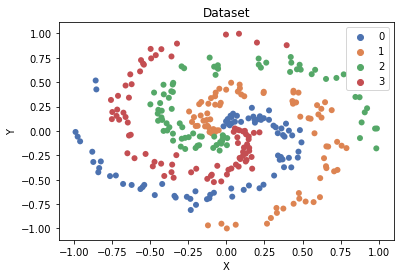

In [3]:
sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = y_, palette = sns.color_palette('deep', K), edgecolor = "none")
plt.title('Dataset')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [4]:
def init_para(D, K, h):
    # initialize parameters randomly
    W = np.random.normal(0, 0.01, (D, h))
    b = np.zeros((1, h), dtype = float)
    W2 = np.random.normal(0, 0.01, (h, K))
    b2 = np.zeros((1, K), dtype = float)
    return W, b, W2, b2

In [5]:
def softmax(scores):
    exp_scores = np.exp(scores)
    return exp_scores / np.sum(exp_scores, axis = 1).reshape(-1, 1)

In [6]:
def nnet(X, y, step_size = 0.4, lam = 0.0001, h = 10, num_iters = 1000):
    # get dim of input
    N, D = X.shape
    K = y.shape[1]
    
    W, b, W2, b2 = init_para(D, K, h)
    
    # gradient descent loop to update weight and bias
    for i in range(num_iters):
        # hidden layer, ReLU activation
        hidden_layer = np.maximum(0, np.dot(X, W) + np.repeat(b, N, axis = 0))
        
        # class score
        scores = np.dot(hidden_layer, W2) + np.repeat(b2, N, axis = 0)

        # compute and normalize class probabilities
        probs = softmax(scores)

        # compute the loss with regularization
        data_loss = np.sum(-np.log(probs) * y) / N
        reg_loss = 0.5 * lam * np.sum(W * W) + 0.5 * lam * np.sum(W2 * W2)
        loss = data_loss + reg_loss
        
        # check progress
        if i%1000 == 0 or i == num_iters:
            print("iteration {}: loss {}".format(i, loss))
        
        # compute the gradient on scores
        dscores = (probs - y) / N

        # backpropate the gradient to the parameters
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis = 0)
        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0
        # finally into W,b
        dW = np.dot(X.T, dhidden)
        db = np.sum(dhidden, axis = 0)

        # add regularization gradient contribution
        dW2 = dW2 + lam * W2
        dW = dW + lam * W

        # update parameter 
        W = W - step_size * dW
        b = b - step_size * db
        W2 = W2 - step_size * dW2
        b2 = b2 - step_size * db2
    return W, b, W2, b2

In [7]:
def predict(X, para):
    W, b, W2, b2 = para
    N = X.shape[0]
    hidden_layer = np.maximum(0, np.dot(X, W) + np.repeat(b, N, axis = 0))
    scores = np.dot(hidden_layer, W2) + np.repeat(b2, N, axis = 0)
    return np.argmax(scores, axis = 1)

In [8]:
num_iters = 10000
para = nnet(X, y, step_size = 0.4, lam = 0.0001, h = 50, num_iters = num_iters)
predicted = predict(X, para)
print('The accuracy is {:.2f} %'.format(sum(predicted == y_)/len(y_)*100))

iteration 0: loss 1.3862024430232744
iteration 1000: loss 0.8668108244811135
iteration 2000: loss 0.36647470911960006
iteration 3000: loss 0.27245049885129696
iteration 4000: loss 0.233685044187733
iteration 5000: loss 0.1943721809077945
iteration 6000: loss 0.16774774814942967
iteration 7000: loss 0.14601942312697935
iteration 8000: loss 0.1379245715217669
iteration 9000: loss 0.13280185934555122
The accuracy is 99.38 %


In [9]:
def prob(X, para, k):
    W, b, W2, b2 = para
    N = X.shape[0]
    hidden_layer = np.maximum(0, np.dot(X, W) + np.repeat(b, N, axis = 0))
    scores = np.dot(hidden_layer, W2) + np.repeat(b2, N, axis = 0)
    probs = softmax(scores)
    return probs.flatten()[k]

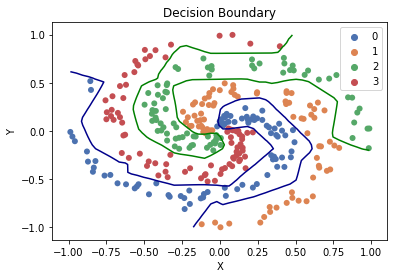

In [10]:
u = np.linspace(min(X[:, 0]),max(X[:, 0]), 50)  
v = np.linspace(min(X[:, 1]),max(X[:, 1]), 50)

for k in range(0, K, 2):
    z = np.zeros((len(u),len(v)))
    for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = prob(np.array([u[i], v[j]]).reshape(1, -1), para, k)   

    z = np.transpose(z)
    plt.contour(u,v,z,[0,0.5], colors = ['darkblue', 'green'][k//2])   
    
sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = y_, palette = sns.color_palette('deep', K), edgecolor = "none")
plt.title('Decision Boundary')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [11]:
gridx, gridy = np.meshgrid(u, v)
grid = np.array([gridx.reshape(-1, ), gridy.reshape(-1, )]).T
z = predict(grid, para).reshape(50, 50)

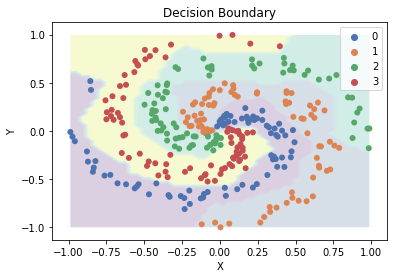

In [12]:
plt.contourf(u,v,z, alpha = 0.2, antialiased = True)   
    
sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = y_, palette = sns.color_palette('deep', K), edgecolor = "none")
plt.title('Decision Boundary')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [13]:
train = np.loadtxt('data/train.csv', delimiter = ',', skiprows = 1)
test = np.loadtxt('data/test.csv', delimiter = ',', skiprows = 1)

In [14]:
trainx, trainy_ = train[:, 1:], train[:, 0].flatten()
trainx_norm = trainx/255

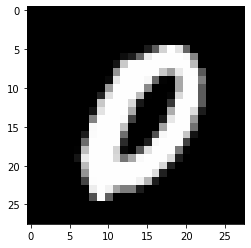

In [21]:
idx = np.random.randint(trainx.shape[0])
plt.imshow(trainx[idx].reshape(28, 28), cmap='gray')
plt.show()

In [17]:
trainy = np.zeros((trainx.shape[0], 10), dtype = int)
for i, v in enumerate(trainy_):
    trainy[i, int(v)] = 1

In [19]:
num_iters = 2000
mnist_para = nnet(trainx_norm, trainy, step_size = 0.4, lam = 0.001, h = 10, num_iters = num_iters)
predicted = predict(trainx_norm, mnist_para)
print('The accuracy is {:.2f} %'.format(sum(predicted == trainy_)/len(trainy_)*100))

iteration 0: loss 2.3031767963469556
iteration 1000: loss 0.2723747823444944
The accuracy is 94.08 %


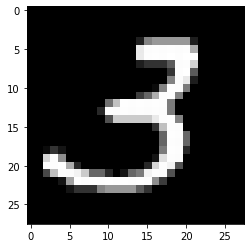

The predicted number is 3


In [27]:
idx = np.random.randint(test.shape[0])
plt.imshow(test[idx].reshape(28, 28), cmap='gray')
plt.show()
print('The predicted number is {}'.format(predict(test[idx]/255, mnist_para)[0]))